# PyTorch Custom Datasets

We've used some datasets with PyTorch before, but how do you get your own data into PyTorch?

In [2]:
import torch
from torch import nn

torch.__version__

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Choose Your Data

We will try and build a model working with [LiDAR data](https://en.wikipedia.org/wiki/Lidar).

I have a dataset of segmented point-cloud data, so we can take the segmented trees from a bigger LiDAR point cloud. This segmented trees are also labeled tree by tree... later we'll visualize them to better grasp their structure.

First we'll connect the notebook with Google Drive:

In [3]:
# We'll use files contained in my Gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's read the .las file and turn into a numpy array.

In [4]:
las_file_path = '/content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T60_R4.0_tree.las'

In [5]:
!pip install  laspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.7 MB/s eta 0:00:00


In [6]:
# write a function to get a np array from las files
import numpy as np
import laspy

def read_las_file_to_numpy(file_path, features_to_extract=None):
    """
    Reads a LAS file, extracts coordinate data (x, y, z), specific features and labels,
    and returns them as a numpy array.

    Parameters:
    - file_path (str): The path to the LAS file.
    - features_to_extract (list): List of features to extract from the LAS file.

    Returns:
    - np.ndarray: A numpy array containing the extracted data from the LAS file.
    - feature_names (list of str): List of feature names corresponding to the columns in the array.
    """
    # Read the LAS file
    print(f"Processing {file_path}...")
    las_data = laspy.read(file_path)

    # Initialize a list to store the features and their names
    data = []

    # Check if x, y, z coordinates are present
    if hasattr(las_data, 'x') and hasattr(las_data, 'y') and hasattr(las_data, 'z'):
        if len(las_data.x) > 0 and len(las_data.y) > 0 and len(las_data.z) > 0:
            # Add x, y, z as the first columns
            data.append(las_data.x)
            data.append(las_data.y)
            data.append(las_data.z)
        else:
            print(f"Warning: One of the coordinate arrays (x, y, z) is empty in {file_path}.")
            return None
    else:
        print(f"Warning: LAS data in {file_path} does not have 'x', 'y', or 'z' attributes.")
        return None

    # Extract additional features
    available_features = []
    missing_features = []
    for feature in features_to_extract:
        if feature in ['x', 'y', 'z']:
            continue  # Skip if feature is x, y, or z since they are already added
        if feature in las_data.point_format.dimension_names:
            data.append(las_data[feature])
            available_features.append(feature)
        else:
            missing_features.append(feature)

    # Warn if any requested features are missing
    if missing_features:
        print(f"Warning: The following features were not found in the LAS file: {missing_features}")

    # Add selected features to feature_names
    feature_names = ['x', 'y', 'z']
    feature_names += available_features

    # Convert the data list to a numpy array and transpose to match the expected shape (N, num_features)
    data_array = np.vstack(data).T
    print(f"Loaded NumPy array with shape: {data_array.shape}")

    return data_array, feature_names


In [28]:
features_to_extract = ['x', 'y', 'z', 'intensity', 'tree']

np_points, feature_names = read_las_file_to_numpy(las_file_path, features_to_extract=features_to_extract)

Processing /content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T60_R4.0_tree.las...
Loaded NumPy array with shape: (55569, 5)


In [29]:
print(f"Tree point cloud stored as np with {np_points.shape[0]} points. \nVector shape: {np_points.shape}")

Tree point cloud stored as np with 55569 points. 
Vector shape: (55569, 5)


Let's write a function to visualize these points:

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_point_cloud_scaled(np_points, save=False, file_path=None):
    """
    Plots a 3D scatter plot of a point cloud with equal scaling for all axes.

    Args:
    - np_points (np.ndarray): N x 3 or N x F numpy array, with at least x, y, z in the first 3 columns.
    - save (bool): If True, saves the plot to file.
    - file_path (str): Path to save the plot (only if save is True).
    """
    x = np_points[:, 0]
    y = np_points[:, 1]
    z = np_points[:, 2]
    tree = np_points[:, -1]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=tree, cmap='viridis', s=0.2)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    if save and file_path:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        plt.savefig(file_path)
        plt.close()
    else:
        plt.show()


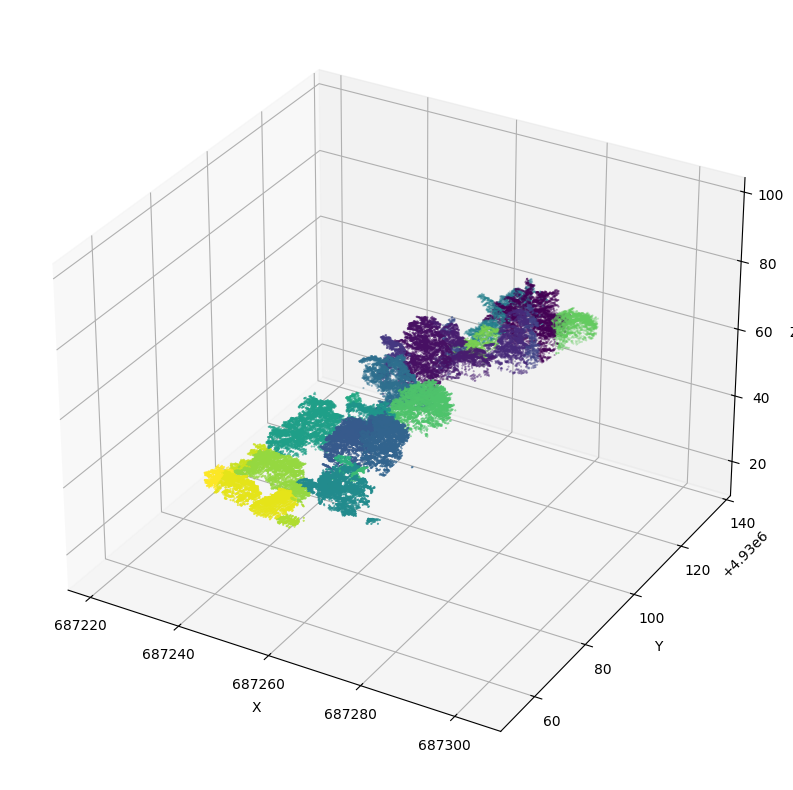

In [25]:
plot_point_cloud_scaled(np_points)

How about some more files?

Processing /content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T30_R7.5_tree.las...
Loaded NumPy array with shape: (25255, 5)


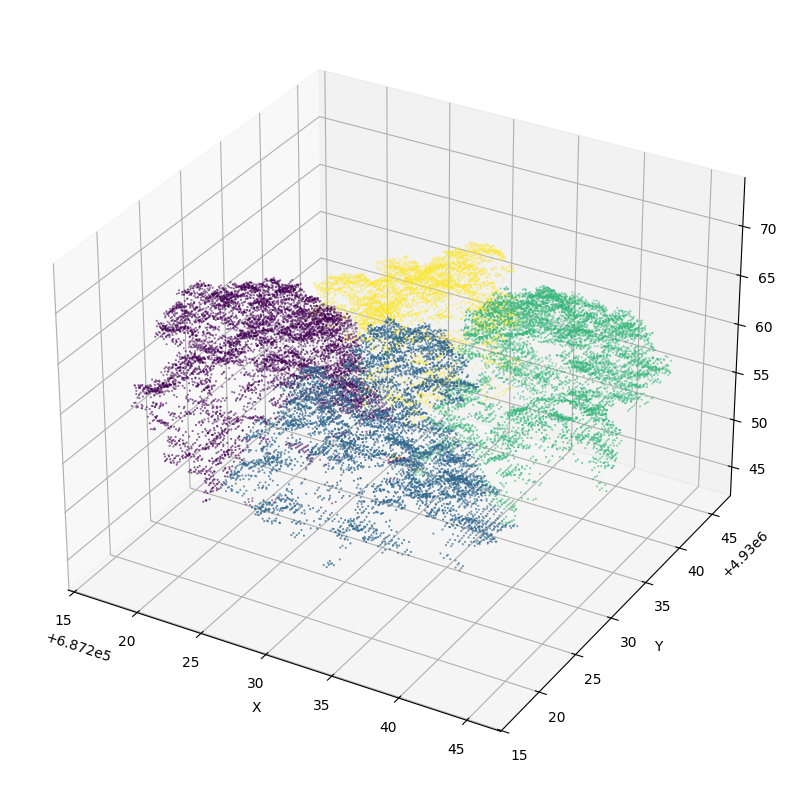

In [31]:
las_file_path2 = '/content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T30_R7.5_tree.las'

np_points2, feature_names2 = read_las_file_to_numpy(las_file_path2, features_to_extract=features_to_extract)

plot_point_cloud_scaled(np_points2)

Processing /content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T25_R4.0_tree.las...
Loaded NumPy array with shape: (66142, 5)


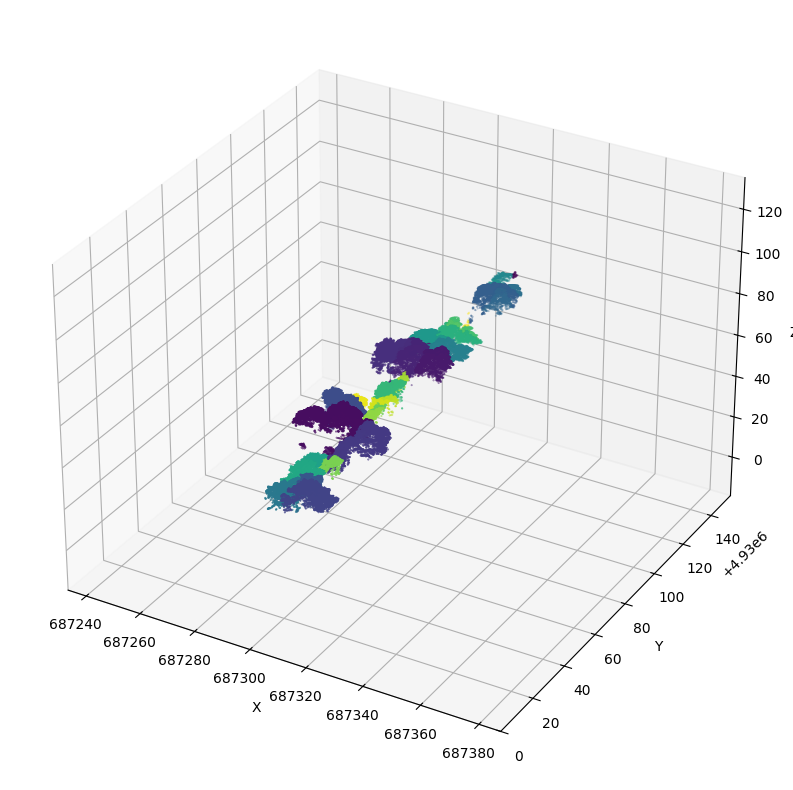

In [34]:
las_file_path3 = '/content/drive/My Drive/DIFA/32_687000_4930000_FP31fS_T25_R4.0_tree.las'

np_points3, feature_names3 = read_las_file_to_numpy(las_file_path3, features_to_extract=features_to_extract)

plot_point_cloud_scaled(np_points3)

Alright, now we may want to split the data into training and test data, right?

Since our data already has a "structure" itself - its divided into trees - we might want to divide between training trees and test trees.



In [ ]:
# stack all arrays together

# loop through data and store trees in an array

# take 80% of those trees for training and 20% for testing

# save them into data/trees/train and data/trees/test